In [74]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import seaborn as sns
import matplotlib.gridspec as gridspec


from BSE import market_session

import matplotlib.pyplot as plt

# Set global font sizes
plt.rcParams['font.size'] = 18  # Default font size for all text
plt.rcParams['axes.titlesize'] = 18  # Font size for plot titles
plt.rcParams['axes.labelsize'] = 18  # Font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 18  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 18  # Font size for y tick labels
plt.rcParams['legend.fontsize'] = 18  # Font size for legend
plt.rcParams['figure.titlesize'] = 18  # Font size for figure titles


In [75]:
id = 'new_trader_chart_0_'
#id = 'heston_model_session_0_'
file_path = id + 'LOB_frames.csv'
prices = id + "tape.csv"
volumes = id + 'blotters.csv'
balances = id + 'avg_balance.csv'


In [76]:
# Initialize lists
time_list, bid_total_quantity, bid_prices, bid_quantities = [], [], [], []
ask_total_quantity, ask_prices, ask_quantities = [], [], []

# Read the file and parse the data
with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        
        # Split the line using "Bid:" and "Ask:" as delimiters
        parts = re.split(r'(Bid:|Ask:)', line)
        time_stamp = float(parts[0].strip().rstrip(','))
        
        # Parse bid and ask data
        bid_data, ask_data = [], []
        for i in range(1, len(parts) - 1, 2):
            values = [int(val) for val in parts[i + 1].strip().split(',') if val.strip().isdigit()]
            if parts[i] == 'Bid:':
                bid_data = values
            elif parts[i] == 'Ask:':
                ask_data = values
        
        # Extract and assign bid data
        if bid_data:
            bid_total_quantity.append(bid_data[0])
            bid_prices.append(bid_data[1::2])  # Take prices at odd indices
            bid_quantities.append(bid_data[2::2])  # Take quantities at even indices
        else:
            bid_total_quantity.append(None)
            bid_prices.append([])
            bid_quantities.append([])
        
        # Extract and assign ask data
        if ask_data:
            ask_total_quantity.append(ask_data[0])
            ask_prices.append(ask_data[1::2])  # Take prices at odd indices
            ask_quantities.append(ask_data[2::2])  # Take quantities at even indices
        else:
            ask_total_quantity.append(None)
            ask_prices.append([])
            ask_quantities.append([])

        # Store the timestamp
        time_list.append(time_stamp)

# Create the expanded DataFrame
expanded_df = pd.DataFrame({
    'Time': time_list,
    'Bid Total Quantity': bid_total_quantity,
    'Bid Prices': [', '.join(map(str, prices)) for prices in bid_prices],
    'Bid Quantities': [', '.join(map(str, quantities)) for quantities in bid_quantities],
    'Ask Total Quantity': ask_total_quantity,
    'Ask Prices': [', '.join(map(str, prices)) for prices in ask_prices],
    'Ask Quantities': [', '.join(map(str, quantities)) for quantities in ask_quantities]
})

# Display the expanded DataFrame
expanded_df.head(10)


,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities
0,0.000,0,,,0,,
1,0.327,1,56,1,0,,
2,0.365,2,"12, 56","1, 1",0,,
3,0.477,2,"12, 56","1, 1",1,57,1
4,0.546,2,"12, 56","1, 1",0,,
5,0.562,3,"12, 20, 56","1, 1, 1",0,,
6,0.577,3,"12, 56, 207","1, 1, 1",0,,
7,0.585,3,"12, 56, 131","1, 1, 1",0,,
8,0.638,3,"12, 56, 154","1, 1, 1",0,,
9,0.723,3,"56, 60, 154","1, 1, 1",0,,


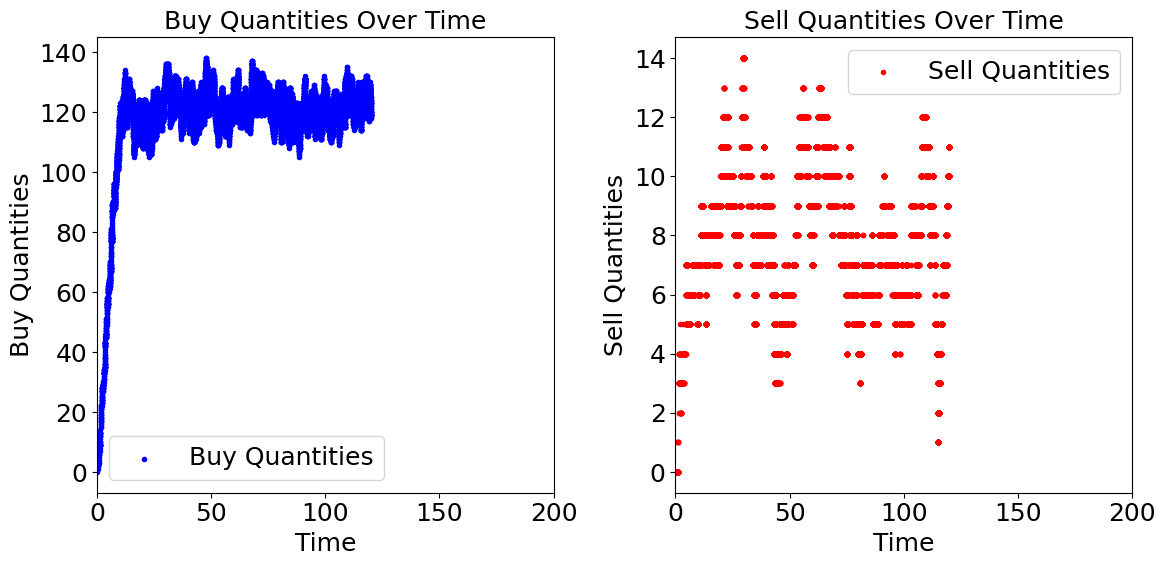

In [77]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot buy quantities
axs[0].scatter(time_list, bid_total_quantity, label='Buy Quantities', color='blue', marker = '.')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Buy Quantities')
axs[0].set_title('Buy Quantities Over Time')
axs[0].legend()
#axs[0].grid(True)

# Plot sell quantities
axs[1].scatter(time_list, ask_total_quantity, label='Sell Quantities', color='red', marker = '.')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Sell Quantities')
axs[1].set_title('Sell Quantities Over Time')
axs[1].legend()
#axs[1].grid(True)

# Show the plots
axs[0].set_xlim(00,200)
axs[1].set_xlim(00,200)
#axs[0].set_ylim(0,30)
#axs[1].set_ylim(0,30)
plt.tight_layout()
plt.show()

In [78]:
import numpy as np
import pandas as pd

df = expanded_df.sort_values('Time')
df = df.reset_index(drop=True)

events = []
for i in range(1, len(df)):
    t0 = df.loc[i-1, 'Time']
    t1 = df.loc[i, 'Time']
    
    bid_prev = df.loc[i-1, 'Bid Total Quantity']
    bid_curr = df.loc[i, 'Bid Total Quantity']
    ask_prev = df.loc[i-1, 'Ask Total Quantity']
    ask_curr = df.loc[i, 'Ask Total Quantity']
    
    # Figure out net changes:
    delta_bid = bid_curr - bid_prev
    delta_ask = ask_curr - ask_prev
    
    # Heuristic classification
    if delta_bid > 0 and delta_ask == 0:
        event_side = 'buy'
    elif delta_ask > 0 and delta_bid == 0:
        event_side = 'sell'
    else:
        # you can refine logic; maybe skip or label as 'other'
        event_side = 'other'
    
    if event_side != 'other':
        events.append((t1, event_side))

events_df = pd.DataFrame(events, columns=['Time', 'Side'])


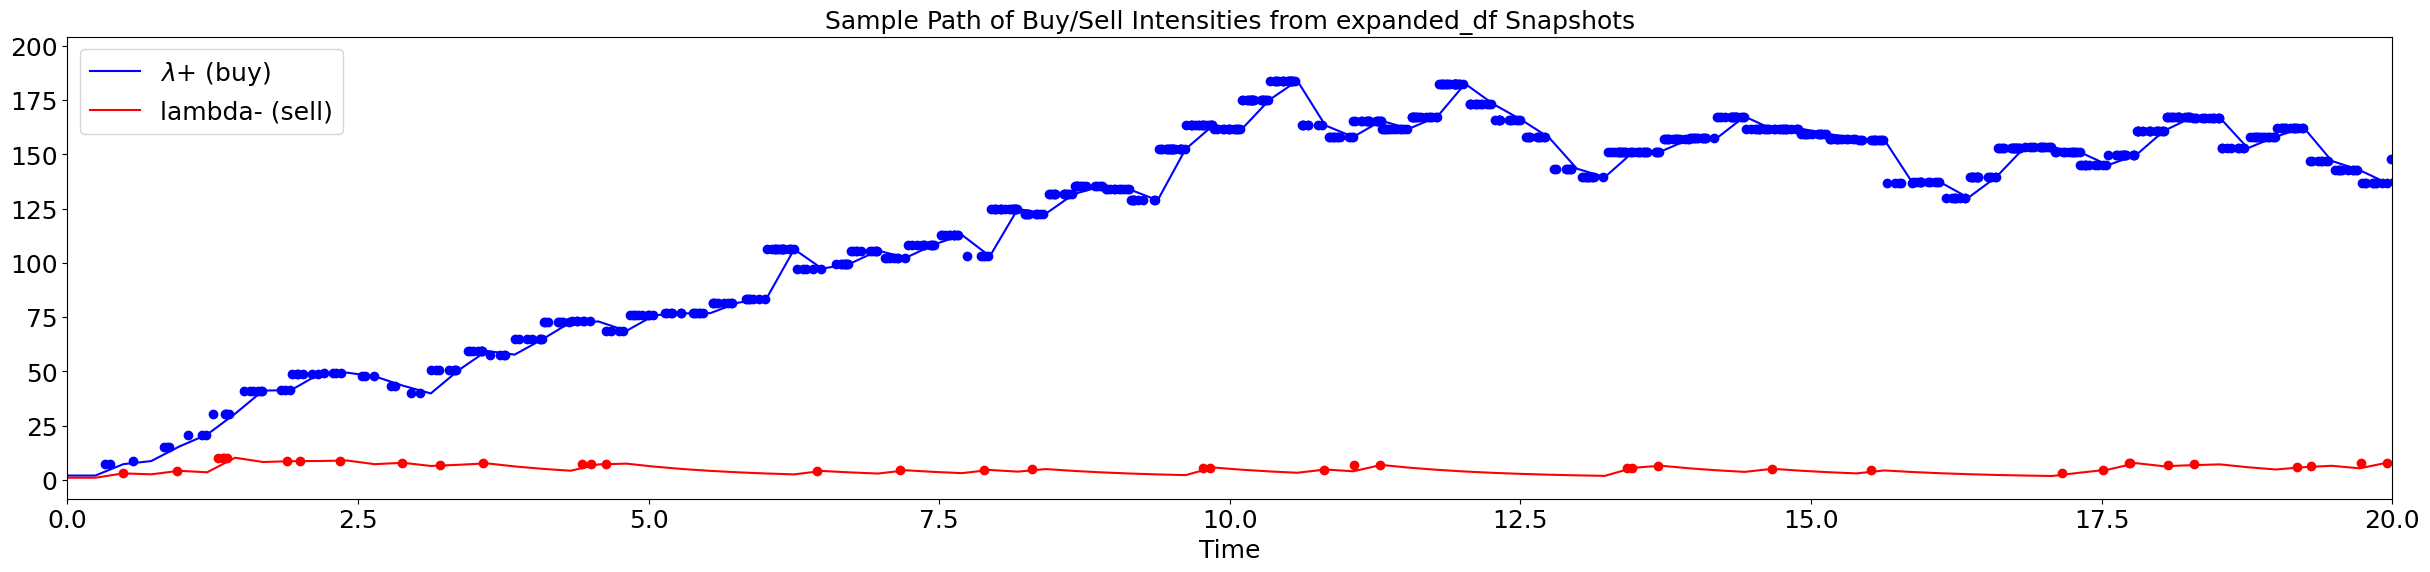

In [79]:
import matplotlib.pyplot as plt

# Suppose some baseline intensities:
lambda_plus_0 = 2.0
lambda_minus_0 = 1.0
decay_rate = 1.0

# We'll pick a fine time grid from the first to last event time:
t_min = df['Time'].min()
t_max = df['Time'].max()
times = np.linspace(t_min, t_max, 500)

# Build intensities on this grid.
lambda_plus = np.zeros_like(times) + lambda_plus_0
lambda_minus = np.zeros_like(times) + lambda_minus_0

# For a simple approach, do a Hawkes-like sum of exponentials:
jump_size_buy = 3.0
jump_size_sell = 2.0

for (tevent, side) in events:
    # contribution from each event:
    idx = times >= tevent
    if side == 'buy':
        lambda_plus[idx] += jump_size_buy * np.exp(-decay_rate*(times[idx] - tevent))
    elif side == 'sell':
        lambda_minus[idx] += jump_size_sell * np.exp(-decay_rate*(times[idx] - tevent))

# Now plot
fig, ax = plt.subplots(figsize=(30, 6))
plt.plot(times, lambda_plus, label='$\lambda$+ (buy)', color='blue')
plt.plot(times, lambda_minus, label='lambda- (sell)', color='red')

# Mark the event points
for (tevent, side) in events:
    idx = np.searchsorted(times, tevent)
    if side == 'buy':
        plt.plot(tevent, lambda_plus[idx], 'o', color='blue')
    else:
        plt.plot(tevent, lambda_minus[idx], 'o', color='red')

plt.xlabel('Time')
plt.title('Sample Path of Buy/Sell Intensities from expanded_df Snapshots')
plt.legend()
plt.xlim(0,20)
plt.show()


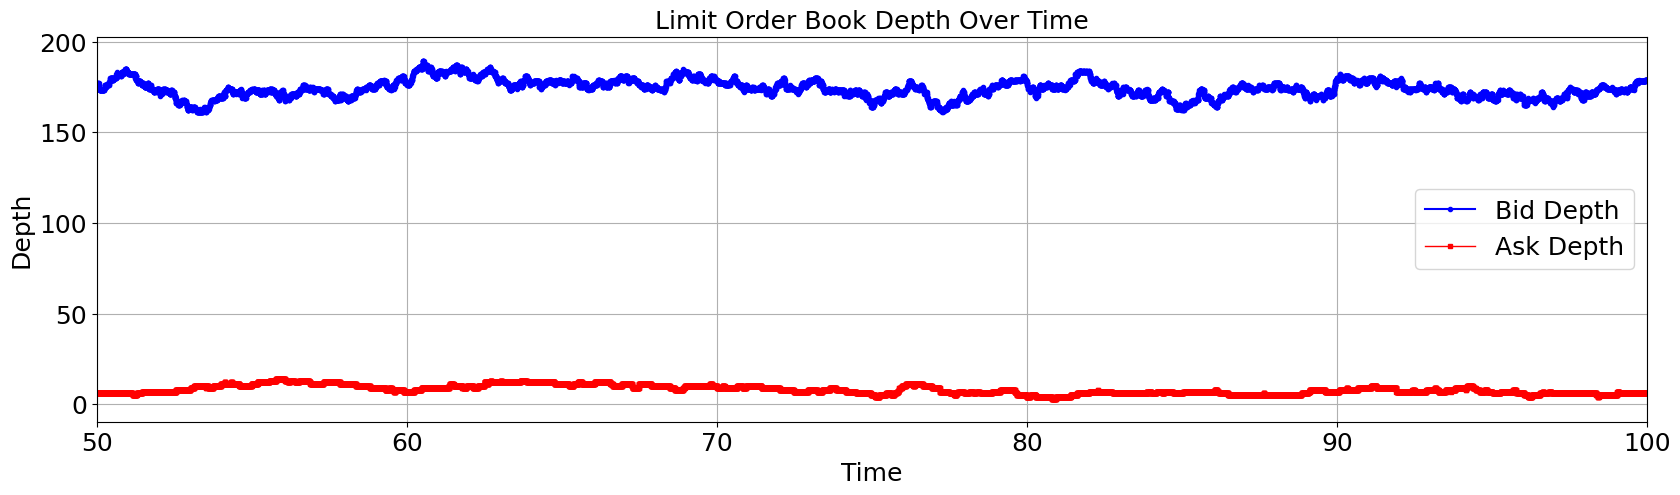

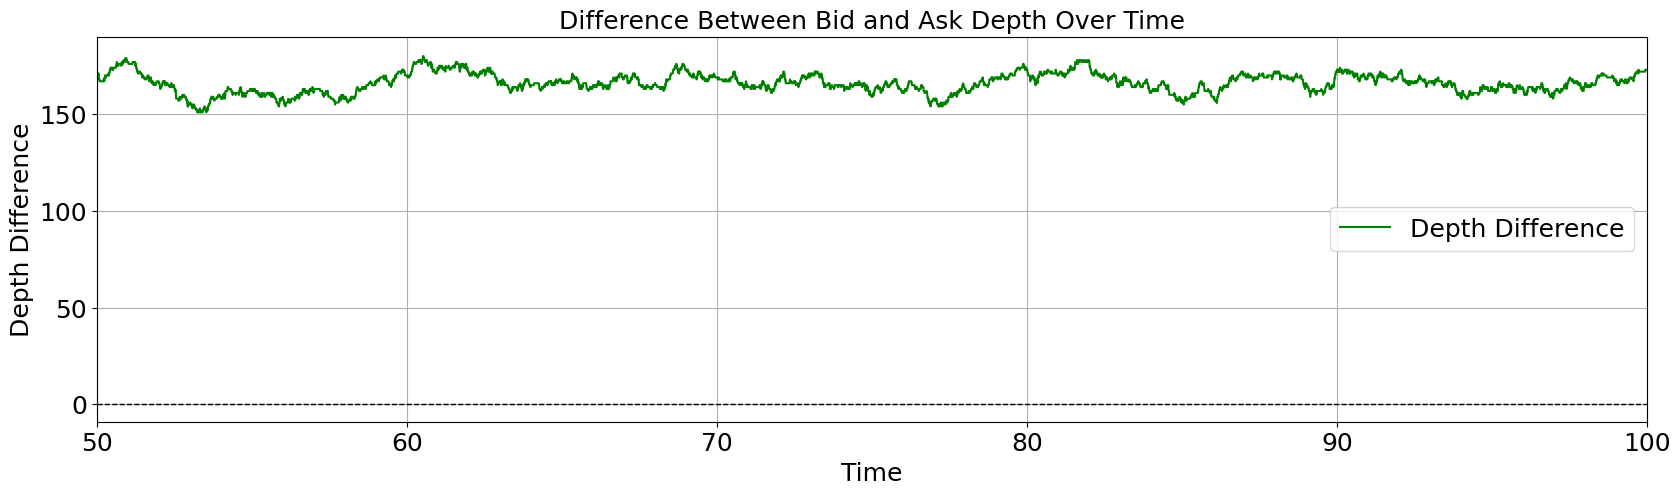

In [80]:
# Function to safely convert bid/ask quantities into lists of integers
def safe_convert_quantities(value):
    if isinstance(value, list):
        return value  # Already a list
    if isinstance(value, str):
        try:
            return [int(x) for x in value.split(',') if x.strip().isdigit()]
        except ValueError:
            return []
    return []

# Apply the safe conversion to the Bid and Ask Quantities columns
expanded_df["Bid Quantities"] = expanded_df["Bid Quantities"].apply(safe_convert_quantities)
expanded_df["Ask Quantities"] = expanded_df["Ask Quantities"].apply(safe_convert_quantities)

# Compute Bid and Ask Depth
expanded_df["Bid Depth"] = expanded_df["Bid Quantities"].apply(sum)
expanded_df["Ask Depth"] = expanded_df["Ask Quantities"].apply(sum)

# Plot the Bid and Ask Depth over Time
plt.figure(figsize=(20, 5))
plt.plot(expanded_df["Time"], expanded_df["Bid Depth"], marker=".", linestyle="-", label="Bid Depth", color = 'blue')
plt.plot(expanded_df["Time"], expanded_df["Ask Depth"], marker="s", linestyle="-", label="Ask Depth", color = 'red', markersize=3, linewidth=1)
plt.xlabel("Time")
plt.ylabel("Depth")
plt.xlim(50,100)
plt.legend()
plt.grid()
plt.title("Limit Order Book Depth Over Time")
# Calculate the difference between Bid Depth and Ask Depth
expanded_df["Depth Difference"] = expanded_df["Bid Depth"] - expanded_df["Ask Depth"]

# Plot the Depth Difference over Time
plt.figure(figsize=(20, 5))
plt.plot(expanded_df["Time"], expanded_df["Depth Difference"], marker="none", linestyle="-", label="Depth Difference", color='green')
plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Baseline at y=0
plt.xlabel("Time")
plt.ylabel("Depth Difference")
plt.title("Difference Between Bid and Ask Depth Over Time")
plt.legend()
plt.grid()

# Show plot
plt.xlim(50,100)
plt.show()
# Plot the Depth Difference over Time as a bar chart
#plt.figure(figsize=(20, 5))
#plt.bar(expanded_df["Time"], expanded_df["Depth Difference"], color='black', label="Depth Difference")
#plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Baseline at y=0
#plt.xlabel("Time")
#plt.ylabel("Depth Difference")
#plt.title("Difference Between Bid and Ask Depth Over Time")
#plt.legend()
#plt.grid()

# Show plot
#plt.xlim(50, 100)
#plt.show()


Need to plot the fill rate, should decrease as it varies from the midpoint
Have to use the LOB and whent rades occured to find teh rates 

In [81]:
def parse_price_string(price_str):
    """
    Given a string like '3,4,5,6', parse and return [3, 4, 5, 6] as integers.
    If the cell is empty or None, return an empty list.
    """
    if not price_str:  # handles None or empty
        return []
    # Split on commas and convert each piece to int
    return [int(p) for p in price_str.split(',') if p.strip().isdigit()]

# Parse the Bid Prices and Ask Prices columns into lists of integers
expanded_df['ParsedBidPrices'] = expanded_df['Bid Prices'].apply(parse_price_string)
expanded_df['ParsedAskPrices'] = expanded_df['Ask Prices'].apply(parse_price_string)

# Compute the highest bid and lowest ask at each timestamp
expanded_df['HighestBid'] = expanded_df['ParsedBidPrices'].apply(lambda prices: max(prices) if prices else None)
expanded_df['LowestAsk'] = expanded_df['ParsedAskPrices'].apply(lambda prices: min(prices) if prices else None)

# Display the resulting DataFrame with the new columns
expanded_df[['Time', 'HighestBid', 'LowestAsk']].head(20)

,Time,HighestBid,LowestAsk
0,0.000,NaN,NaN
1,0.327,56.0,NaN
2,0.365,56.0,NaN
3,0.477,56.0,57.0
4,0.546,56.0,NaN
5,0.562,56.0,NaN
6,0.577,207.0,NaN
7,0.585,131.0,NaN
8,0.638,154.0,NaN
9,0.723,154.0,NaN


In [82]:
expanded_df['MidPrice'] = 0.5 * (expanded_df['HighestBid'] + expanded_df['LowestAsk'])

In [83]:
# Initialize an empty list to store each trade as a dictionary
trades = []

# Variable to keep track of the current trader ID
current_trader = None

# Open and read the CSV file line by line
with open(volumes, 'r') as file:
    for line in file:
        parts = line.strip().split(', ')
        
        # Check if line indicates a new trader's trade count (e.g., "B00, 8")
        if len(parts) == 2 and parts[1].isdigit():
            current_trader = parts[0]  # Set the trader ID (e.g., "B00")
        
        # Check if line has enough parts to be a trade entry
        elif len(parts) >= 7:
            # Create a dictionary for each trade entry
            trade = {
                'TraderID': current_trader,
                'Type': parts[1],
                'Timestamp': float(parts[2]),
                'Price': int(parts[3]),
                'Seller': parts[4],
                'Buyer': parts[5],
                'Quantity': int(parts[6])
            }
            trades.append(trade)
        else:
            print(f"Skipping line due to unexpected format: {line}")

# Convert the list of trades to a DataFrame
blotters = pd.DataFrame(trades)

# Display the resulting DataFrame
blotters.head(5)

,TraderID,Type,Timestamp,Price,Seller,Buyer,Quantity
0,B00,Trade,115.115,270,B00,S17,1
1,B01,Trade,41.377,255,B01,S32,1
2,B02,Trade,65.496,261,B02,S04,1
3,B02,Trade,99.112,252,B02,S07,1
4,B03,Trade,70.300,247,B03,S05,1


In [84]:
# Sort the blotters DataFrame by the Timestamp column in ascending order
blotters_sorted = blotters.sort_values(by='Timestamp').reset_index(drop=True)

# Display the sorted DataFrame
blotters_sorted.head(10)

,TraderID,Type,Timestamp,Price,Seller,Buyer,Quantity
0,S28,Trade,0.546,57,S28,B180,1
1,B180,Trade,0.546,57,S28,B180,1
2,S33,Trade,0.973,169,S33,B50,1
3,B50,Trade,0.973,169,S33,B50,1
4,B188,Trade,1.265,214,B188,S00,1
5,S00,Trade,1.265,214,B188,S00,1
6,S25,Trade,1.477,214,B172,S25,1
7,B172,Trade,1.477,214,B172,S25,1
8,B200,Trade,1.792,199,B200,S01,1
9,S01,Trade,1.792,199,B200,S01,1


In [85]:
expanded_df['MidPrice'] = 0.5 * (expanded_df['HighestBid'] + expanded_df['LowestAsk'])
expanded_df['BuyDepth'] = blotters['Price'] - expanded_df['HighestBid']  
expanded_df['SellDepth'] = expanded_df['LowestAsk'] - blotters['Price']

expanded_df.head(10)

,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities,Bid Depth,Ask Depth,Depth Difference,ParsedBidPrices,ParsedAskPrices,HighestBid,LowestAsk,MidPrice,BuyDepth,SellDepth
0,0.000,0,,[],0,,[],0,0,0,[],[],NaN,NaN,NaN,NaN,NaN
1,0.327,1,56,[1],0,,[],1,0,1,[56],[],56.0,NaN,NaN,199.0,NaN
2,0.365,2,"12, 56","[1, 1]",0,,[],2,0,2,"[12, 56]",[],56.0,NaN,NaN,205.0,NaN
3,0.477,2,"12, 56","[1, 1]",1,57,[1],2,1,1,"[12, 56]",[57],56.0,57.0,56.5,196.0,-195.0
4,0.546,2,"12, 56","[1, 1]",0,,[],2,0,2,"[12, 56]",[],56.0,NaN,NaN,191.0,NaN
5,0.562,3,"12, 20, 56","[1, 1, 1]",0,,[],3,0,3,"[12, 20, 56]",[],56.0,NaN,NaN,216.0,NaN
6,0.577,3,"12, 56, 207","[1, 1, 1]",0,,[],3,0,3,"[12, 56, 207]",[],207.0,NaN,NaN,73.0,NaN
7,0.585,3,"12, 56, 131","[1, 1, 1]",0,,[],3,0,3,"[12, 56, 131]",[],131.0,NaN,NaN,163.0,NaN
8,0.638,3,"12, 56, 154","[1, 1, 1]",0,,[],3,0,3,"[12, 56, 154]",[],154.0,NaN,NaN,132.0,NaN
9,0.723,3,"56, 60, 154","[1, 1, 1]",0,,[],3,0,3,"[56, 60, 154]",[],154.0,NaN,NaN,112.0,NaN


In [86]:
# Merge trades with order book data using Timestamp
merged_df = expanded_df.merge(blotters_sorted, left_on='Time', right_on='Timestamp', how='left')

# Fill NaN values (if no trade occurred at a specific order book update, assume 0 market orders)
merged_df['Quantity'] = merged_df['Quantity'].fillna(0)

merged_df.head(20)


,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities,Bid Depth,Ask Depth,Depth Difference,...,MidPrice,BuyDepth,SellDepth,TraderID,Type,Timestamp,Price,Seller,Buyer,Quantity
0,0.000,0,,[],0,,[],0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0.327,1,56,[1],0,,[],1,0,1,...,NaN,199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0.365,2,"12, 56","[1, 1]",0,,[],2,0,2,...,NaN,205.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0.477,2,"12, 56","[1, 1]",1,57,[1],2,1,1,...,56.5,196.0,-195.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0.546,2,"12, 56","[1, 1]",0,,[],2,0,2,...,NaN,191.0,NaN,S28,Trade,0.546,57.0,S28,B180,1.0
5,0.546,2,"12, 56","[1, 1]",0,,[],2,0,2,...,NaN,191.0,NaN,B180,Trade,0.546,57.0,S28,B180,1.0
6,0.562,3,"12, 20, 56","[1, 1, 1]",0,,[],3,0,3,...,NaN,216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,0.577,3,"12, 56, 207","[1, 1, 1]",0,,[],3,0,3,...,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,0.585,3,"12, 56, 131","[1, 1, 1]",0,,[],3,0,3,...,NaN,163.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,0.638,3,"12, 56, 154","[1, 1, 1]",0,,[],3,0,3,...,NaN,132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [87]:
# Replace zero or negative depths with NaN to avoid divide-by-zero errors
merged_df.loc[merged_df['BuyDepth'] <= 0, 'BuyDepth'] = None
merged_df.loc[merged_df['SellDepth'] <= 0, 'SellDepth'] = None

# Compute Fill Rates
merged_df['FillRate_Buy'] = merged_df['Quantity'] / merged_df['BuyDepth']
merged_df['FillRate_Sell'] = merged_df['Quantity'] / merged_df['SellDepth']

# Fill NaN values (if depth was 0, assume no liquidity to fill)
merged_df[['FillRate_Buy', 'FillRate_Sell']] = merged_df[['FillRate_Buy', 'FillRate_Sell']].fillna(0)


In [88]:
# Compute Fill Rates
merged_df['FillRate_Buy'] = merged_df['Quantity'] / merged_df['BuyDepth']
merged_df['FillRate_Sell'] = merged_df['Quantity'] / merged_df['SellDepth']

# Fill NaN values (if depth was 0, assume no liquidity was filled)
merged_df[['FillRate_Buy', 'FillRate_Sell']] = merged_df[['FillRate_Buy', 'FillRate_Sell']].fillna(0)

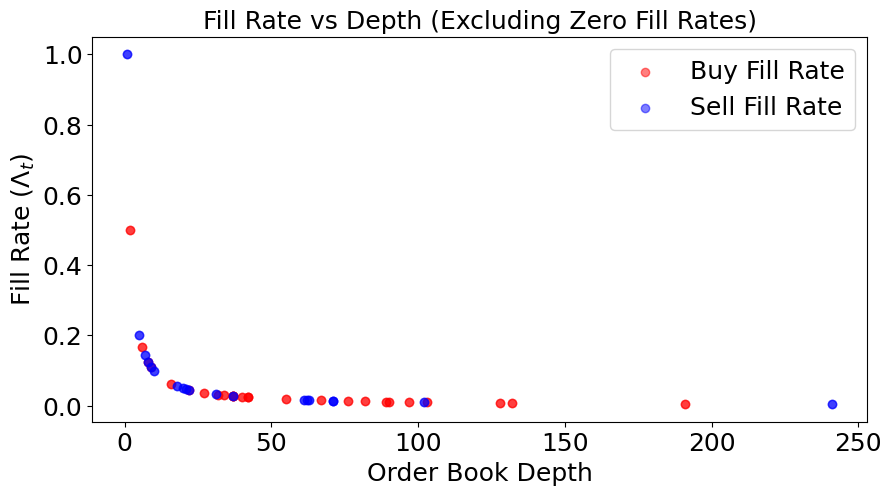

In [89]:
import matplotlib.pyplot as plt

# Ensure merged_df exists before plotting
if 'merged_df' in locals() or 'merged_df' in globals():
    plt.figure(figsize=(10, 5))

    # Filter out points where Fill Rate is zero
    buy_fill_data = merged_df[merged_df['FillRate_Buy'] > 0]
    sell_fill_data = merged_df[merged_df['FillRate_Sell'] > 0]

    # Scatter plot of Fill Rate vs Depth for Buy and Sell orders (excluding zero fill rates)
    plt.scatter(buy_fill_data['BuyDepth'], buy_fill_data['FillRate_Buy'], color='red', alpha=0.5, label='Buy Fill Rate')
    plt.scatter(sell_fill_data['SellDepth'], sell_fill_data['FillRate_Sell'], color='blue', alpha=0.5, label='Sell Fill Rate')

    # Labels and Title
    plt.xlabel("Order Book Depth")
    plt.ylabel("Fill Rate ($\Lambda_t$)")
    plt.title("Fill Rate vs Depth (Excluding Zero Fill Rates)")
    plt.legend()

    # Show plot
    plt.show()
else:
    print("Error: merged_df is not defined. Please reload your data and recompute the fill rates.")


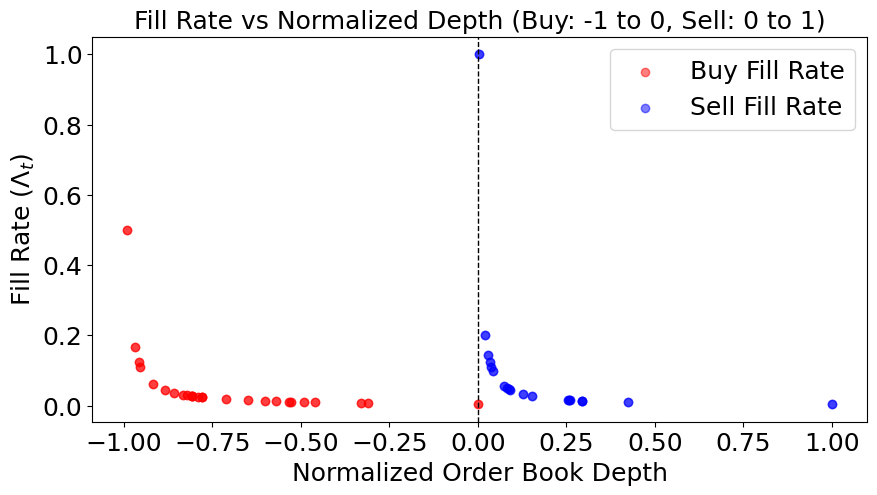

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure merged_df exists before proceeding
if 'merged_df' in locals() or 'merged_df' in globals():
    plt.figure(figsize=(10, 5))

    # Filter out zero fill rates
    buy_fill_data = merged_df[merged_df['FillRate_Buy'] > 0].copy()
    sell_fill_data = merged_df[merged_df['FillRate_Sell'] > 0].copy()

    # Normalize Depth: Scale Buy Depth to [-1, 0] and Sell Depth to [0, 1]
    buy_fill_data['Normalized_BuyDepth'] = -1 + (buy_fill_data['BuyDepth'] / buy_fill_data['BuyDepth'].max())
    sell_fill_data['Normalized_SellDepth'] = sell_fill_data['SellDepth'] / sell_fill_data['SellDepth'].max()

    # Scatter plot of Normalized Fill Rate vs Depth
    plt.scatter(buy_fill_data['Normalized_BuyDepth'], buy_fill_data['FillRate_Buy'], color='red', alpha=0.5, label='Buy Fill Rate')
    plt.scatter(sell_fill_data['Normalized_SellDepth'], sell_fill_data['FillRate_Sell'], color='blue', alpha=0.5, label='Sell Fill Rate')

    # Labels and Title
    plt.xlabel("Normalized Order Book Depth")
    plt.ylabel("Fill Rate ($\Lambda_t$)")
    plt.title("Fill Rate vs Normalized Depth (Buy: -1 to 0, Sell: 0 to 1)")
    plt.axvline(x=0, color='black', linestyle='dashed', linewidth=1)  # Indicate the mid-price (spread boundary)
    plt.legend()

    # Show plot
    plt.show()
else:
    print("Error: merged_df is not defined. Please reload your data and recompute the fill rates.")


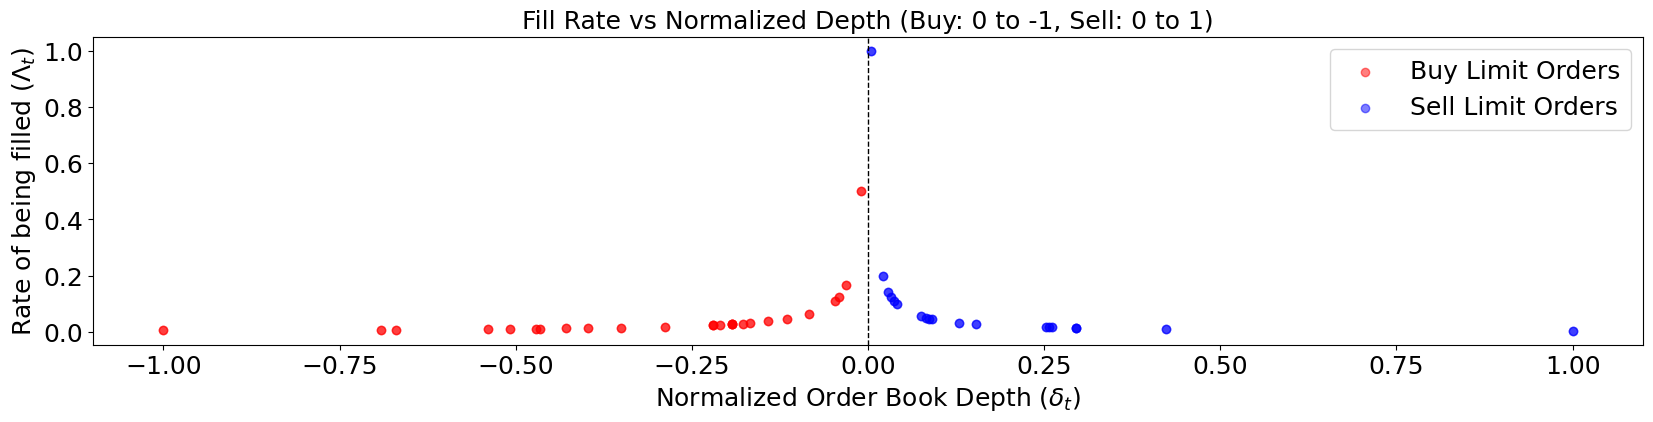

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure merged_df exists before proceeding
if 'merged_df' in locals() or 'merged_df' in globals():
    plt.figure(figsize=(20, 4))

    # Filter out zero fill rates
    buy_fill_data = merged_df[merged_df['FillRate_Buy'] > 0].copy()
    sell_fill_data = merged_df[merged_df['FillRate_Sell'] > 0].copy()

    # FIX: Reverse Buy Depth Normalization so that smaller depths are closer to 0
    buy_fill_data['Normalized_BuyDepth'] = -1 * (buy_fill_data['BuyDepth'] / buy_fill_data['BuyDepth'].max())

    # Sell Depth remains the same (0 to 1)
    sell_fill_data['Normalized_SellDepth'] = sell_fill_data['SellDepth'] / sell_fill_data['SellDepth'].max()

    # Scatter plot of Normalized Fill Rate vs Depth
    plt.scatter(buy_fill_data['Normalized_BuyDepth'], buy_fill_data['FillRate_Buy'], color='red', alpha=0.5, label='Buy Limit Orders')
    plt.scatter(sell_fill_data['Normalized_SellDepth'], sell_fill_data['FillRate_Sell'], color='blue', alpha=0.5, label='Sell Limit Orders')

    # Labels and Title
    plt.xlabel("Normalized Order Book Depth ($\delta _t$)")
    plt.ylabel("Rate of being filled ($\Lambda_t$)")
    plt.title("Fill Rate vs Normalized Depth (Buy: 0 to -1, Sell: 0 to 1)")
    plt.axvline(x=0, color='black', linestyle='dashed', linewidth=1)  # Midpoint (spread)
    plt.legend()

    # Show plot
    plt.show()
else:
    print("Error: merged_df is not defined. Please reload your data and recompute the fill rates.")


In [92]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the exponential decay function
def exponential_decay(delta, lambda_, kappa):
    return lambda_ * np.exp(-kappa * delta)


In [93]:
# Filter valid fill rate data (exclude zeros)
buy_fill_data = merged_df[merged_df['FillRate_Buy'] > 0].copy()
sell_fill_data = merged_df[merged_df['FillRate_Sell'] > 0].copy()

# Normalize Depth: Scale Buy Depth to [-1, 0] and Sell Depth to [0, 1]
buy_fill_data['Normalized_BuyDepth'] = -1 * (buy_fill_data['BuyDepth'] / buy_fill_data['BuyDepth'].max())
sell_fill_data['Normalized_SellDepth'] = sell_fill_data['SellDepth'] / sell_fill_data['SellDepth'].max()

# Fit exponential decay model for buy orders
popt_buy, _ = curve_fit(exponential_decay, buy_fill_data['Normalized_BuyDepth'], buy_fill_data['FillRate_Buy'], p0=[1, 1])
lambda_minus, kappa_minus = popt_buy  # Extract fitted parameters

# Fit exponential decay model for sell orders
popt_sell, _ = curve_fit(exponential_decay, sell_fill_data['Normalized_SellDepth'], sell_fill_data['FillRate_Sell'], p0=[1, 1])
lambda_plus, kappa_plus = popt_sell  # Extract fitted parameters

# Display the estimated parameters
print(f"Estimated Parameters:")
print(f"λ⁻ (Buy Side): {lambda_minus:.3f}, κ⁻ (Buy Side Decay Rate): {kappa_minus:.3f}")
print(f"λ⁺ (Sell Side): {lambda_plus:.3f}, κ⁺ (Sell Side Decay Rate): {kappa_plus:.3f}")


Estimated Parameters:
λ⁻ (Buy Side): 0.772, κ⁻ (Buy Side Decay Rate): -43.183
λ⁺ (Sell Side): 1.373, κ⁺ (Sell Side Decay Rate): 78.795


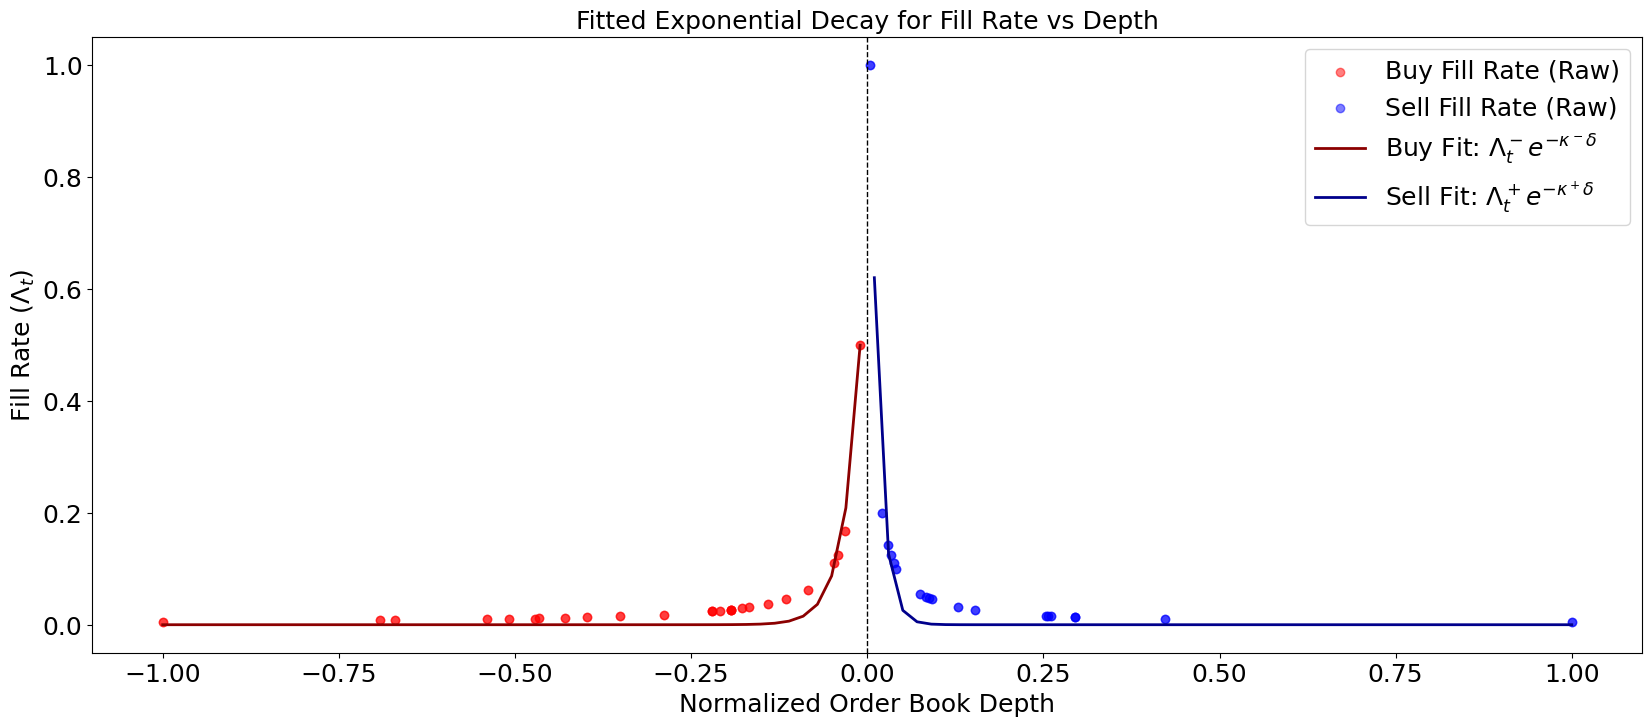

In [94]:
# Generate smooth x-axis points for fitted curves
depth_range = np.linspace(-1, 1, 100)
plt.figure(figsize=(20, 8))


# Compute fitted curves
fit_buy = exponential_decay(depth_range[depth_range < 0], lambda_minus, kappa_minus)
fit_sell = exponential_decay(depth_range[depth_range >= 0], lambda_plus, kappa_plus)

# Plot scatter points (raw data)
plt.scatter(buy_fill_data['Normalized_BuyDepth'], buy_fill_data['FillRate_Buy'], color='red', alpha=0.5, label='Buy Fill Rate (Raw)')
plt.scatter(sell_fill_data['Normalized_SellDepth'], sell_fill_data['FillRate_Sell'], color='blue', alpha=0.5, label='Sell Fill Rate (Raw)')

# Plot fitted curves
plt.plot(depth_range[depth_range < 0], fit_buy, color='darkred', linestyle='-', linewidth=2, label=r'Buy Fit: $\Lambda_t^- e^{-\kappa^- \delta}$')
plt.plot(depth_range[depth_range >= 0], fit_sell, color='darkblue', linestyle='-', linewidth=2, label=r'Sell Fit: $\Lambda_t^+ e^{-\kappa^+ \delta}$')

# Labels and Title
plt.xlabel("Normalized Order Book Depth")
plt.ylabel("Fill Rate ($\Lambda_t$)")
plt.title("Fitted Exponential Decay for Fill Rate vs Depth")
plt.axvline(x=0, color='black', linestyle='dashed', linewidth=1)  # Spread boundary
plt.legend()

# Show plot
plt.show()


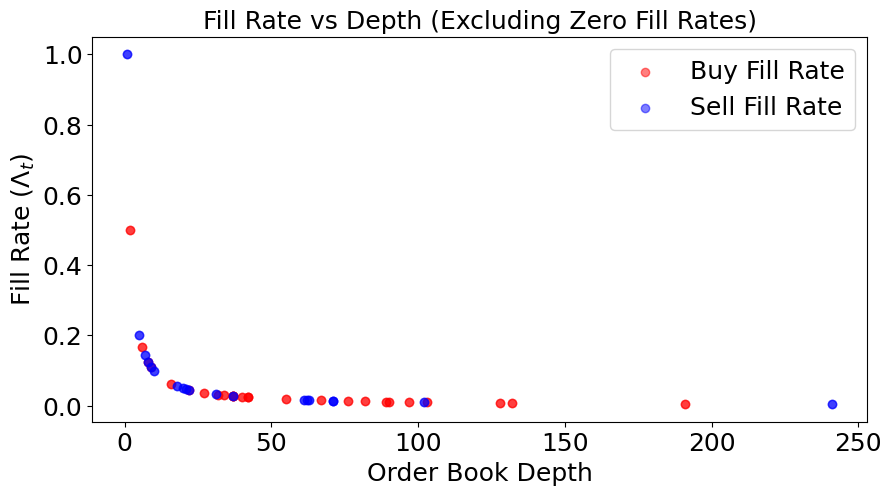

In [95]:
import matplotlib.pyplot as plt

# Ensure merged_df exists before plotting
if 'merged_df' in locals() or 'merged_df' in globals():
    plt.figure(figsize=(10, 5))

    # Filter out points where Fill Rate is zero
    buy_fill_data = merged_df[merged_df['FillRate_Buy'] > 0]
    sell_fill_data = merged_df[merged_df['FillRate_Sell'] > 0]

    # Scatter plot of Fill Rate vs Depth for Buy and Sell orders (excluding zero fill rates)
    plt.scatter(buy_fill_data['BuyDepth'], buy_fill_data['FillRate_Buy'], color='red', alpha=0.5, label='Buy Fill Rate')
    plt.scatter(sell_fill_data['SellDepth'], sell_fill_data['FillRate_Sell'], color='blue', alpha=0.5, label='Sell Fill Rate')

    # Labels and Title
    plt.xlabel("Order Book Depth")
    plt.ylabel("Fill Rate ($\Lambda_t$)")
    plt.title("Fill Rate vs Depth (Excluding Zero Fill Rates)")
    plt.legend()

    # Show plot
    plt.show()
else:
    print("Error: merged_df is not defined. Please reload your data and recompute the fill rates.")

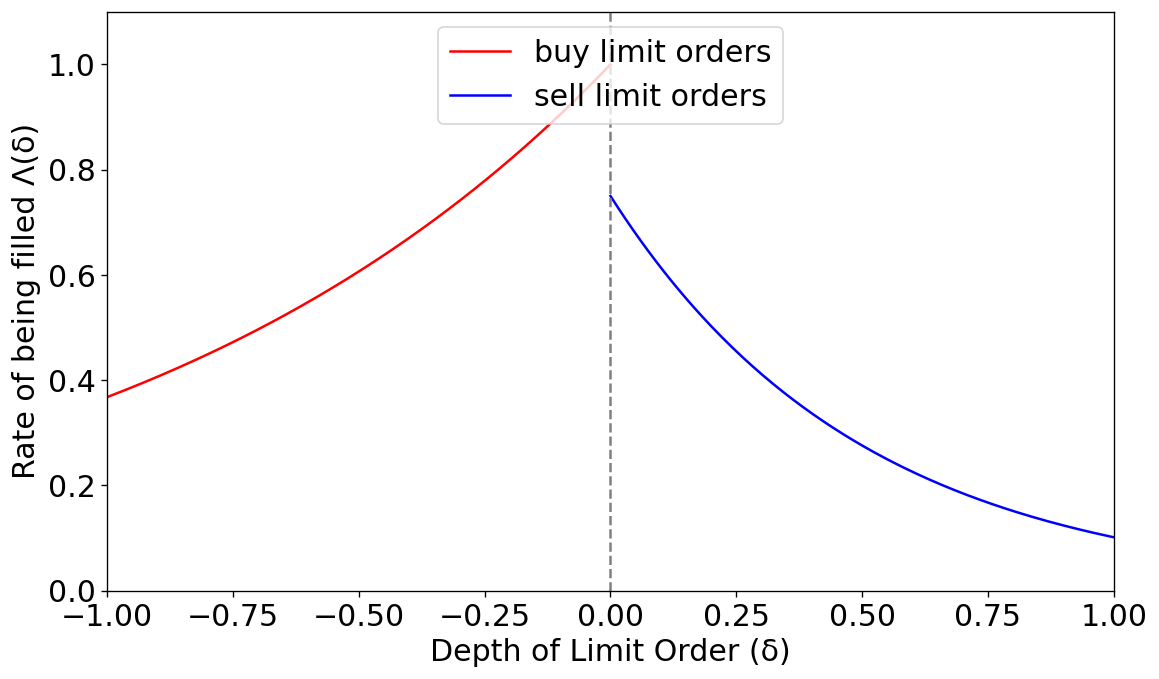

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters from the example figure
kappa_minus = 1.0   # shape for buy side
kappa_plus  = 2.0   # shape for sell side
lambda_minus = 1.0  # activity rate for buy side
lambda_plus  = 0.75 # activity rate for sell side

# Define depth range (delta):
#   negative deltas = buy side
#   positive deltas = sell side
delta_buy  = np.linspace(-1.0, 0.0, 200)  # from -1 to 0
delta_sell = np.linspace(0.0,  1.0, 200)  # from 0 to 1

# Fill-rate function (exponential model):
#  For buy orders (δ < 0):  Λ⁻(δ) = λ⁻ * exp(kappa⁻ * δ)
#  For sell orders (δ > 0): Λ⁺(δ) = λ⁺ * exp(-kappa⁺ * δ)

fill_rate_buy  = lambda_minus * np.exp(kappa_minus * delta_buy)
fill_rate_sell = lambda_plus  * np.exp(-kappa_plus * delta_sell)

# Plotting
plt.figure(figsize=(10,6), dpi=120)

# Plot buy side (red)
plt.plot(delta_buy, fill_rate_buy, color='red', label='buy limit orders')

# Plot sell side (blue)
plt.plot(delta_sell, fill_rate_sell, color='blue', label='sell limit orders')

# Vertical dashed line at delta=0 for reference
plt.axvline(x=0, color='gray', linestyle='--')

# Labels, legend, etc.
plt.xlabel('Depth of Limit Order (δ)')
plt.ylabel('Rate of being filled Λ(δ)')
plt.ylim(0, 1.1)  # adjust if you want more vertical space
plt.xlim(-1, 1)
plt.legend(loc='upper center')

plt.tight_layout()
plt.show()
